In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import glob
import os
# from alive_progress import alive_it
from tqdm import tqdm

# data

In [2]:
# df = pd.read_csv("data/v1.0.0_work_laptop.csv")
df = pd.read_csv("data/v1.0.0_personal_laptop.csv")
df

,image_path,subject_ID,image_number,gender,glasses,eye_state,reflections,image_quality,sensor_type,label
0,/Users/haidiazaman/Desktop/datasets/small_imag...,s0030,663,0,0,1,0,1,1,open
1,/Users/haidiazaman/Desktop/datasets/small_imag...,s0030,486,0,0,1,0,1,1,open
2,/Users/haidiazaman/Desktop/datasets/small_imag...,s0030,384,0,0,1,0,1,1,open
3,/Users/haidiazaman/Desktop/datasets/small_imag...,s0030,782,0,0,1,0,1,1,open
4,/Users/haidiazaman/Desktop/datasets/small_imag...,s0030,764,0,0,1,0,1,1,open
...,...,...,...,...,...,...,...,...,...,...
84893,/Users/haidiazaman/Desktop/datasets/small_imag...,s0016,534,1,0,0,1,1,1,close
84894,/Users/haidiazaman/Desktop/datasets/small_imag...,s0016,1793,1,0,1,0,1,1,open
84895,/Users/haidiazaman/Desktop/datasets/small_imag...,s0016,331,1,0,0,0,1,1,close
84896,/Users/haidiazaman/Desktop/datasets/small_imag...,s0016,709,1,0,0,0,1,1,close


In [3]:
df = df.iloc[:1000]
df.label.value_counts()

open     759
close    241
Name: label, dtype: int64

In [4]:
# train test split
from sklearn.model_selection import train_test_split

train,test = train_test_split(df,test_size=0.1,shuffle=True,random_state=1,stratify=df[['label','gender', 'glasses','reflections', 'image_quality']])
train,val = train_test_split(train,test_size=2/7,shuffle=True,random_state=1,stratify=train[['label','gender', 'glasses','reflections', 'image_quality']])

In [5]:
len(train),len(val),len(test)

train.label.value_counts()/len(train),val.label.value_counts()/len(val),test.label.value_counts()/len(test)

(open     0.758567
 close    0.241433
 Name: label, dtype: float64,
 open     0.75969
 close    0.24031
 Name: label, dtype: float64,
 open     0.76
 close    0.24
 Name: label, dtype: float64)

In [6]:
# # find what the min_dim for the dataset is, that should resize all images to a number close to that, so that small images are not upsampled to larger dim instead
# min_dim = np.float64("inf")
# for i,row in tqdm(df.sample(n=10000).iterrows()):
#     dims = plt.imread(row['image_path']).shape
#     dims = min(dims)
#     if dims<min_dim:
#         min_dim=dims

# min_dim

should use a try except function and read all the files to ensure that all images are actually readable and not corrupt, should also set a threshold on min_dims so that weird images that are too small arent used

In [7]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, RandomCrop, ColorJitter, Normalize, InterpolationMode

def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
    
    
class EyeDataset(Dataset):
    def __init__(self,df,split_type,input_dim):
        self.split_type = split_type
        self.input_dim = input_dim

        self.image_paths = df.image_path.tolist()
        self.labels = df.label.tolist()
        self.mapping = {
            "close":0,
            "open":1,
        }
        
    def __len__(self):
        return len(self.image_paths)       
        
    def __getitem__(self,ind):
        image = load_image(self.image_paths[ind])
        label = self.mapping[self.labels[ind]]

        if self.split_type=='train':
            # apply train transforms
            train_transforms = Compose([
                ToTensor(),  # Converts to torch tensor and normalizes to [0,1]
                Resize((self.input_dim, self.input_dim)),  # Resize to the specified input dimensions
                RandomHorizontalFlip(),  # Randomly flip the image horizontally with a probability of 0.5
                RandomRotation(10,interpolation=InterpolationMode.BILINEAR),  # Randomly rotate the image by ±10 degrees
                RandomCrop(self.input_dim, padding=4),  # Randomly crop the image with padding
                ColorJitter(brightness=0.2, contrast=0.2),  # Slightly adjust brightness and contrast
                Normalize(mean=[0], std=[1])  
            ])
            image = train_transforms(image)
        
        else:
            # apply val and test transforms, resize, normalise, totensor
            val_transforms = Compose([
                ToTensor(), # converts to type torch tensor and normalise to [0,1]
                Resize((self.input_dim,self.input_dim)),
                Normalize(mean=[0], std=[1])  
            ])
            image = val_transforms(image)
       
        
        return image,label

torch.Size([1, 50, 50])


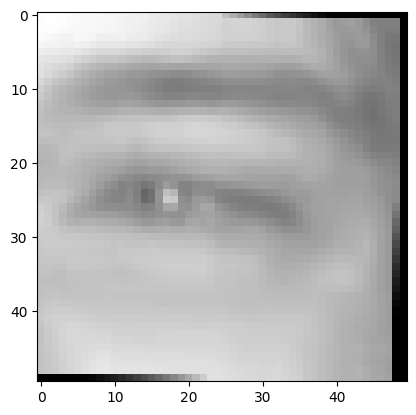

In [8]:
sample_dataset = EyeDataset(
    df=train,
    split_type='train',
    input_dim=50
)

i=np.random.randint(0,len(sample_dataset),1).item()
print(sample_dataset[i][0].shape)
plt.imshow(sample_dataset[i][0].permute(1,2,0),cmap='gray')
plt.show()

torch.Size([1, 50, 50])


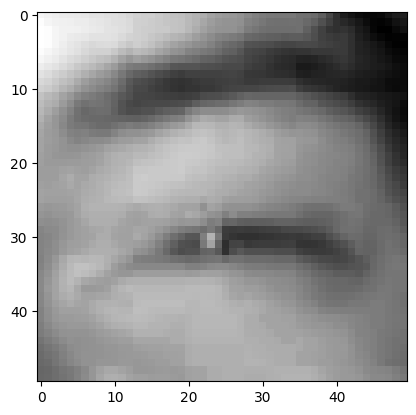

In [9]:
sample_dataset = EyeDataset(
    df=test,
    split_type='test',
    input_dim=50
)

i=np.random.randint(0,len(sample_dataset),1).item()
print(sample_dataset[i][0].shape)
plt.imshow(sample_dataset[i][0].permute(1,2,0),cmap='gray')
plt.show()

In [10]:
# initialise dataset
input_dim = 64

train_dataset = EyeDataset(
    df=train,
    split_type='train',
    input_dim=input_dim
)

val_dataset = EyeDataset(
    df=val,
    split_type='val',
    input_dim=input_dim
)

test_dataset = EyeDataset(
    df=test,
    split_type='test',
    input_dim=input_dim
)

In [11]:
test_dataset.__len__()

100

In [12]:
# dataloader

batch_size = 32

from torch.utils.data import DataLoader

train_dl = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle=True,
)

val_dl = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    shuffle=False,
)

test_dl = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle=False,
)

In [13]:
batch = next(iter(train_dl))
x_batch,y_batch = batch
x_batch.shape,y_batch.shape

(torch.Size([32, 1, 64, 64]), torch.Size([32]))

train_dl


15it [00:00, 856.36it/s]


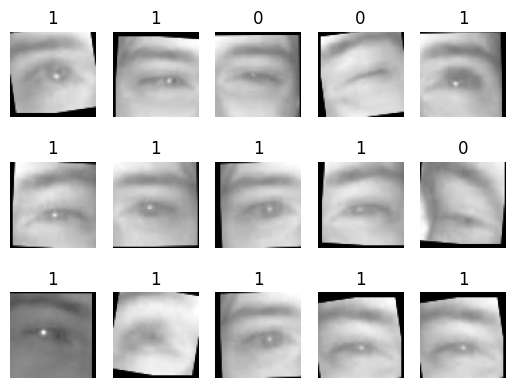

In [14]:
print("train_dl")

rows,cols=3,5
fig,ax=plt.subplots(rows,cols)

for i,ind in tqdm(enumerate(np.random.randint(0,batch_size,rows*cols))):
    img,label = x_batch[ind],y_batch[ind]

    plt.subplot(rows,cols,i+1)
    plt.imshow(img.permute(1,2,0),cmap='gray')
    plt.title(label.item())
    plt.axis('off')

plt.show()

In [15]:
batch = next(iter(val_dl))
x_batch,y_batch = batch
x_batch.shape,y_batch.shape

(torch.Size([32, 1, 64, 64]), torch.Size([32]))

val_dl


15it [00:00, 925.23it/s]


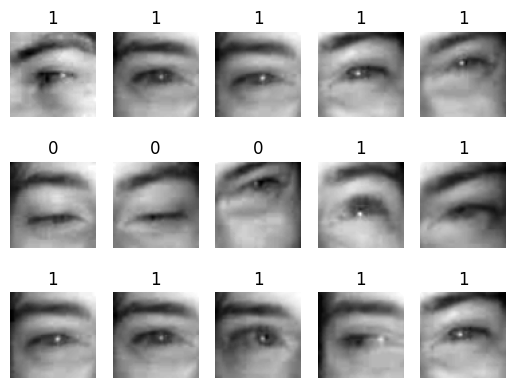

In [16]:
print("val_dl")

rows,cols=3,5
fig,ax=plt.subplots(rows,cols)

for i,ind in tqdm(enumerate(np.random.randint(0,batch_size,rows*cols))):
    img,label = x_batch[ind],y_batch[ind]

    plt.subplot(rows,cols,i+1)
    plt.imshow(img.permute(1,2,0),cmap='gray')
    plt.title(label.item())
    plt.axis('off')

plt.show()

In [17]:
batch = next(iter(test_dl))
x_batch,y_batch = batch
x_batch.shape,y_batch.shape

(torch.Size([32, 1, 64, 64]), torch.Size([32]))

test_dl


15it [00:00, 917.88it/s]


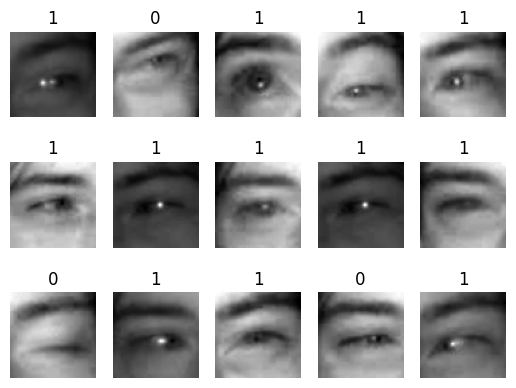

In [18]:
print("test_dl")

rows,cols=3,5
fig,ax=plt.subplots(rows,cols)

for i,ind in tqdm(enumerate(np.random.randint(0,batch_size,rows*cols))):
    img,label = x_batch[ind],y_batch[ind]

    plt.subplot(rows,cols,i+1)
    plt.imshow(img.permute(1,2,0),cmap='gray')
    plt.title(label.item())
    plt.axis('off')

plt.show()

# load MNIST dataset

In [7]:
import torchvision
import torchvision.transforms as transforms

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
train_data = torchvision.datasets.MNIST("data/MNIST", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("data/MNIST", train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3743356.05it/s]


Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 120436.44it/s]


Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 889700.65it/s]


Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2465768.67it/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



In [9]:
train_dataset = train_data.data
test_dataset = test_data.data

train_dataset.shape,test_dataset.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [10]:
mnist_classes = train_data.classes
mnist_class_mapping = train_data.class_to_idx

In [12]:
test_labels = test_data.targets

limit = int(len(train_dataset)*0.8)
val_dataset = train_dataset[limit:]
val_labels = train_data.targets[limit:]
train_dataset = train_dataset[:limit]
train_labels = train_data.targets[:limit]

print(train_dataset.shape,val_dataset.shape,test_dataset.shape)
print(train_labels.shape,val_labels.shape,test_labels.shape)

torch.Size([48000, 28, 28]) torch.Size([12000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([48000]) torch.Size([12000]) torch.Size([10000])


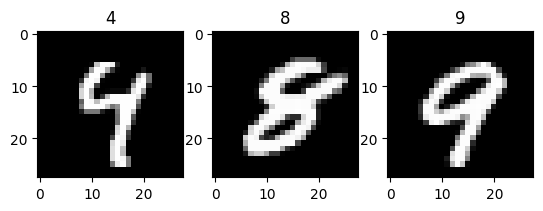

In [13]:
ind = 5002

plt.subplot(1,3,1)
plt.imshow(train_dataset[ind],cmap='gray')
plt.title(train_labels[ind].item())

plt.subplot(1,3,2)
plt.imshow(val_dataset[ind],cmap='gray')
plt.title(val_labels[ind].item())

plt.subplot(1,3,3)
plt.imshow(test_dataset[ind],cmap='gray')
plt.title(test_labels[ind].item())

plt.show()

In [14]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, InterpolationMode

class MnistDataset(Dataset):
    def __init__(self, dataset, labels, split_type):
        self.dataset = dataset
        self.labels = labels
        self.split_type = split_type
        
    def __len__(self): return len(self.dataset)

    def __getitem__(self,index):
        image = self.dataset[index].unsqueeze(0)
        label = self.labels[index]
        
        if self.split_type == 'train':
            tfms = Compose([
                RandomHorizontalFlip(),  # Randomly flip the image horizontally with a probability of 0.5
                RandomRotation(10,interpolation=InterpolationMode.BILINEAR),  # Randomly rotate the image by ±10 degrees
            ])
            
            image = tfms(image)
            
        image = image/255
            
        return image,label

In [15]:
train_dataset = MnistDataset(dataset=train_dataset, labels=train_labels, split_type='train')
val_dataset = MnistDataset(dataset=val_dataset, labels=val_labels, split_type='val')
test_dataset = MnistDataset(dataset=test_dataset, labels=test_labels, split_type='test')

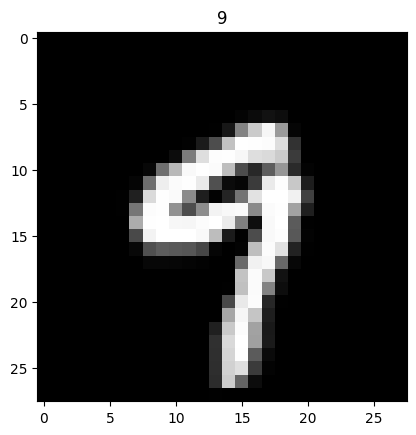

In [16]:
ind = 10023

plt.imshow(train_dataset[ind][0].permute(1,2,0),cmap='gray')
plt.title(train_dataset[ind][1].item())
plt.show()

In [17]:
from torch.utils.data import DataLoader

batch_size = 256

train_dl = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dl = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [18]:
for batch in train_dl:
    images,labels = batch
    break
    
print(images.shape,labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


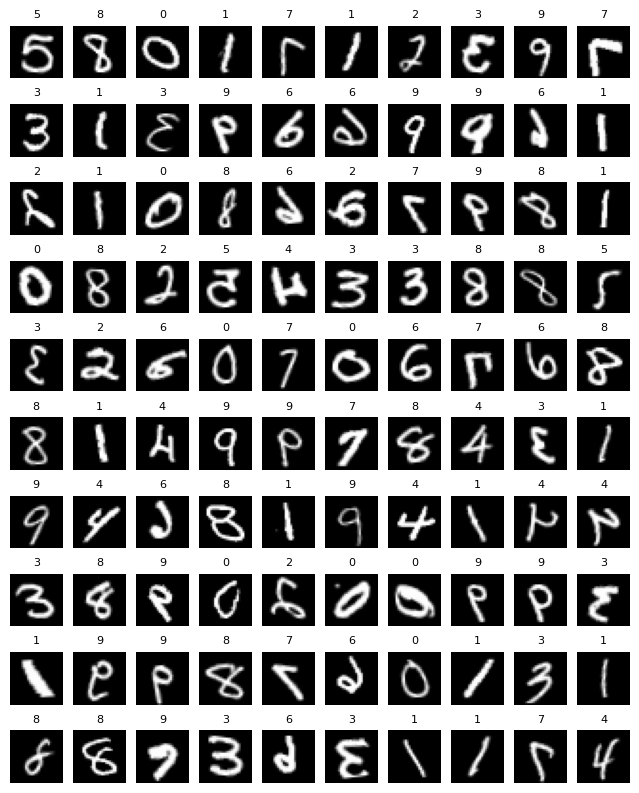

In [19]:
fig,ax = plt.subplots(10,10,figsize=(8,10))

for ind in range(100):
    plt.subplot(10,10,ind+1)
    plt.imshow(images[ind].permute(1,2,0),cmap='gray')
    plt.title(labels[ind].item(),fontsize=8)
    plt.axis('off')
    
plt.show()

In [20]:
for batch in val_dl:
    images,labels = batch
    break
    
print(images.shape,labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


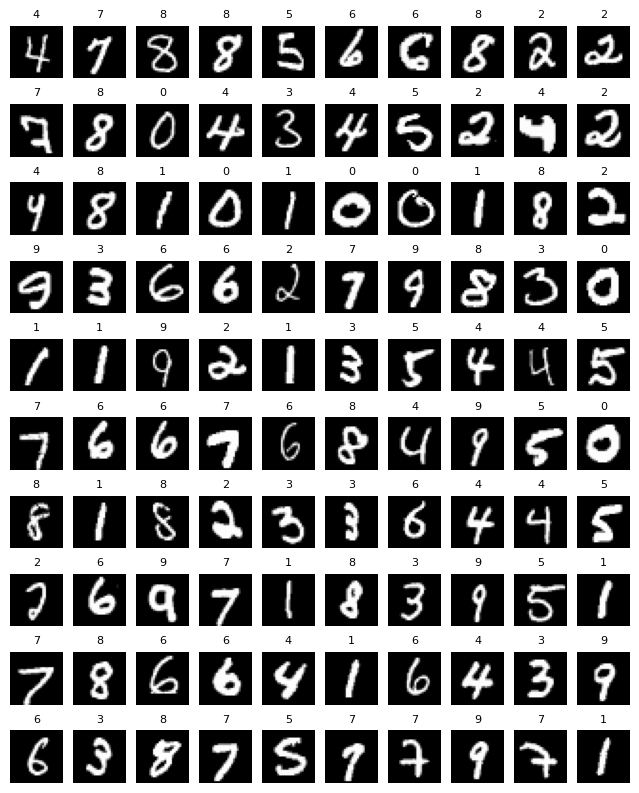

In [21]:
fig,ax = plt.subplots(10,10,figsize=(8,10))

for ind in range(100):
    plt.subplot(10,10,ind+1)
    plt.imshow(images[ind].permute(1,2,0),cmap='gray')
    plt.title(labels[ind].item(),fontsize=8)
    plt.axis('off')
    
plt.show()

In [22]:
for batch in test_dl:
    images,labels = batch
    break
    
print(images.shape,labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


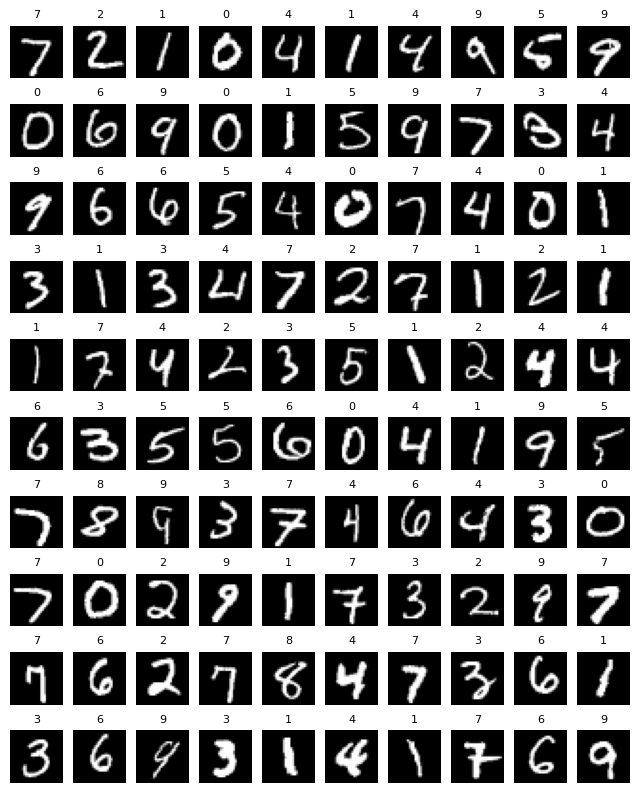

In [23]:
fig,ax = plt.subplots(10,10,figsize=(8,10))

for ind in range(100):
    plt.subplot(10,10,ind+1)
    plt.imshow(images[ind].permute(1,2,0),cmap='gray')
    plt.title(labels[ind].item(),fontsize=8)
    plt.axis('off')
    
plt.show()

In [24]:
images[ind].dtype

torch.float32

# train

In [41]:
# PyTorch for creating and training the neural network
import torch
import torch.nn as nn
import torch.optim as optim

import cv2

# torchvision for loading and transforming the dataset
import torchvision
import torchvision.transforms as transforms

# ReduceLROnPlateau for adjusting the learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau

# numpy for numerical operations
import numpy as np

# matplotlib for plotting
import matplotlib.pyplot as plt

import time

from sklearn.metrics import confusion_matrix

In [212]:
# class AlexNet(nn.Module):
#     """
#     AlexNet model

#     Args:
#         n_dims (int): number of RGB channels. Set to 3 for RGB, 1 for Grayscale image. Default is 3.
#         num_classes (int): number of classes in the dataset. Default is 1000.
#     """
#     def __init__(self, n_dims=3, num_classes=1000):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(n_dims, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         """
#         Forward pass of the model
        
#         Args:
#             x (torch.Tensor): input tensor of shape (N, C, H, W)
        
#         Returns:
#             torch.Tensor: output tensor of shape (N, num_classes)
#         """
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x
    
#     def load_model(self, checkpoint_path):
#         """
#         Load pretrained model
        
#         Args:
#             checkpoint_path: local path of the saved checkpoint
#         """
#         checkpoint = torch.load(checkpoint_path)
#         self.load_state_dict(checkpoint['model_state_dict'])
#         print(f"model loaded from {checkpoint_path}")

In [213]:
# input_dim

In [214]:
# sample_model = AlexNet(n_dims=1,num_classes=2)

# sample_input = torch.tensor(np.random.random((1,1,input_dim,input_dim)),dtype=torch.float32)
# # torch input is batch,channels,height,width
# sample_model(sample_input)

In [217]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        
        self.fcn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,128),
            nn.Linear(128,10),
        )
        
    def forward(self, x):
        x = self.fcn(x)
        
    #     return x
    
    # def load_model(self, checkpoint_path):
    #     """
    #     Load pretrained model
        
    #     Args:
    #         checkpoint_path: local path of the saved checkpoint
    #     """
    #     checkpoint = torch.load(checkpoint_path)
    #     self.load_state_dict(checkpoint['model_state_dict'])
    #     print(f"model loaded from {checkpoint_path}")
        

sample_input = torch.rand(size=(256,1,28,28))
sample_model2 = SimpleNN()
sample_output = sample_model2(sample_input)
sample_output.shape

torch.Size([256, 10])

In [87]:
class SimpleCNN(nn.Module):
    def __init__(self, num_channels):
        super(SimpleCNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fcn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.cnn(x)
        # print(x.shape)
        x = self.fcn(x)
        return x
    
    def load_model(self, checkpoint_path):
        """
        Load pretrained model
        
        Args:
            checkpoint_path: local path of the saved checkpoint
        """
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint['model_state_dict'])
        print(f"model loaded from {checkpoint_path}")


sample_input = torch.rand(size=(256,1,28,28))
sample_model3 = SimpleCNN(num_channels=1)
sample_output = sample_model3(sample_input)
sample_output.shape

torch.Size([256, 10])

In [59]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after

    Args:
    -----
        patience (int): Number of epochs to wait before stopping the training.
        verbose (bool): If True, prints a message for each epoch where the loss
                        does not improve.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        """
        Args:
        -----
            val_loss (float): The validation loss to check if the model performance improved.
        
        Returns:
        --------
            bool: True if the loss did not improve, False if it improved.
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

edit or create a simple Early Stopping class here

In [103]:
class Trainer:
    """
    Trainer class to train the model. Also includes all the other functions required to validate and test the model.
    The purpose of including validation and testing capabilities is to allow direct training in a notebook or G-colab.

    Args:
    -----
        model (nn.Module): Neural network model.
        criterion (torch.nn.modules.loss): Loss function.
        optimizer (torch.optim): Optimizer.
        device (torch.device): Device to run the model on.
        patience (int): Number of epochs to wait before stopping the training.
    """
    def __init__(self, model, criterion, optimizer, device, patience=5):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=3, verbose=True, factor=0.5, min_lr=1e-6)
        self.device = device
        self.early_stopping = EarlyStopping(patience=patience)
        self.train_losses = []
        self.val_losses = []

        
    def resume_training(self, load_path, train_loader, val_loader, epochs, save_path):
        """
        Resume training of the model from a specified epoch checkpoint load_path.
        
        Args:
        -----
            load_path: Pass the local dir path for the checkpoint load_path for training resumption.
            train_loader (torch.utils.data.DataLoader): DataLoader for training dataset.
            val_loader (torch.utils.data.DataLoader): DataLoader for validation dataset.
            epochs (int): Number of epochs to train the model.
            save_path: path for the new folder you want to save the training checkpoints in.
        """  
        # load previous training checkpoint
        epoch_train_loss, epoch_val_loss, epoch_val_acc = self.load_checkpoint(load_path)
        self.train_losses.append(epoch_train_loss)
        self.val_losses.append(epoch_val_loss)
        print(f"loaded training checkpoint from {load_path}")    
        print(f"Pre-training Epoch 0, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Acc: {epoch_val_acc:.4f}")
        print()
        print("##### RESUME TRAINING #####")
        
        # train model      
        self.train(train_loader, val_loader, epochs, save_path)
        
    
    def train(self, train_loader, val_loader, epochs, save_path):
        """
        Train the model.
        
        Args:
        -----
            train_loader (torch.utils.data.DataLoader): DataLoader for training dataset.
            val_loader (torch.utils.data.DataLoader): DataLoader for validation dataset.
            epochs (int): Number of epochs to train the model.
            save_path: path for the new folder you want to save the training checkpoints in.
        """       
        training_start_time = time.time()
        
        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            self.model.train()
            running_loss = 0.0  # Initialize running loss for this epoch
            
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()  # Accumulate the loss for this batch
    
            epoch_train_loss = running_loss / len(train_loader)  # Calculate the average loss for this epoch
            self.train_losses.append(epoch_train_loss)  # Append the average loss to the list

            epoch_val_loss = self.calc_loss(val_loader)
            epoch_val_acc = self.calc_accuracy(val_loader)
            self.val_losses.append(epoch_val_loss)
            self.scheduler.step(epoch_val_loss)
            self.early_stopping(epoch_val_loss)
            
            
            epoch_time_lapsed = time.time() - epoch_start_time
            # Log the training and validation loss
            print(f"Epoch {epoch+1}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Acc: {epoch_val_acc:.4f}, Epoch Duration: {epoch_time_lapsed:.1f}s")

            # save model if val loss drops
            if epoch_val_loss == min(self.val_losses):
                self.save_checkpoint(epoch, epoch_train_loss, epoch_val_loss, epoch_val_acc, save_path)
            
            if self.early_stopping.early_stop:
                print("Early stopping")
                break
                
        training_time_lapsed = time.time() - training_start_time
        print(f"Training Ended, Total Time Lapsed: {training_time_lapsed:.1f}s")
    

    def save_checkpoint(self, epoch, epoch_train_loss, epoch_val_loss, epoch_val_acc, save_path):   
        """
        Save the model checkpoint during training. Checkpoint saved as a dictionary and torch .pt object.
        This function saves the state of the model, optimizer, and scheduler at a specific epoch. 
        This will allow loading of the model for inference or finetuning. 
        Saving the optimizer and scheduler will enable resumption of training in the event of crashing
        during training.

        Args:
        -----
            epoch (int): The current epoch number. This will be used in the checkpoint file name 
            and saved within the checkpoint dictionary.
            epoch_train_loss (float): The current epoch avg train loss.
            epoch_val_loss (float): The current epoch avg val loss.
            epoch_val_acc (float): The current epoch avg val acc.
            save_path: path for the new folder you want to save the training checkpoints in.
        """
        
        # if folder doesnt exist, create it first
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # create model path
        epoch_save_path = f"{save_path}/epoch{epoch+1}.pt"
        
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'epoch_train_loss': epoch_train_loss,
            'epoch_val_loss': epoch_val_loss,
            'epoch_val_acc': epoch_val_acc
        }
        
        torch.save(checkpoint, epoch_save_path)
        print(f"model saved to {epoch_save_path}")

                
    def load_checkpoint(self, load_path):
        """
        Load the optimizer and scheduler from specified epoch. 
        This is done if you would like to resume training from this epoch, e.g. model training crashed.
        Model loading should be done before initialising the Trainer class.
        
        Args:
        -----
            load_path: Pass the local dir path for the checkpoint load_path.
        """
        checkpoint = torch.load(load_path)

        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        epoch_train_loss = checkpoint['epoch_train_loss']
        epoch_val_loss = checkpoint['epoch_val_loss']
        epoch_val_acc = checkpoint['epoch_val_acc']
        
        return epoch_train_loss, epoch_val_loss, epoch_val_acc
            
    
    def calc_loss(self, data_loader):
        """
        Calculate the loss of the model on the train, val or test dataset. 
        Function only works for dataloader types.

        Args:
        -----
            data_loader (torch.utils.data.DataLoader): DataLoader for train, val or test dataset.

        Returns:
        --------
            float: Average loss on the passed dataset.
        """
        self.model.eval()
        running_loss = 0.0  # Initialize running loss for this epoch
        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()  # Accumulate the loss for this batch

        average_loss = running_loss / len(data_loader)  # Calculate the average loss over all batches
        return average_loss
    
    
    def calc_accuracy(self, data_loader):
        """
        Calculate the accuracy of the model when a data_loader is passed, can be train, val or test loader.
        Function only works for dataloader types.

        Args:
        -----
            data_loader (torch.utils.data.DataLoader): DataLoader for train, val or test dataset.

        Returns:
        --------
            float: Accuracy of the model on the passed dataloader.
        """
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        acc = correct / total
        return acc
    
    
    def load_model_for_inference(self, load_path):
        """
        Load the model from specified load_path. This is done for inference only. 
        
        Args:
        -----
            load_path: Pass the local dir path for the checkpoint load_path.
        """
        checkpoint = torch.load(load_path)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        
    def inference_dataloader(self, data_loader):
        """
        Perform inference on a dataloader using the model and return the true labels and predictions.
        Function only works for dataloader types.

        This function runs the model in evaluation mode on the provided data_loader (which can be 
        a train, validation, or test loader), collects all the true labels and model predictions, 
        and returns them for further analysis.

        Args:
        -----
            data_loader (torch.utils.data.DataLoader): DataLoader for the dataset to perform inference on.

        Returns:
        --------
            tuple: A tuple containing two lists:
                - all_labels (list): The ground truth labels for the dataset.
                - all_predictions (list): The model's predicted labels for the dataset.
        """
        self.model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        return all_labels, all_predictions
    

    def calc_confusion_matrix(self, data_loader):
        """
        Calculate the confusion matrix of the model when a data_loader is passed, can be train, val, or test loader.
        Function only works for dataloader types.

        Args:
        -----
            data_loader (torch.utils.data.DataLoader): DataLoader for train, val, or test dataset.

        Returns:
        --------
            numpy.ndarray: Confusion matrix of the model predictions versus actual labels.
        """
        # Get the true labels and predictions of the model
        all_labels, all_predictions = self.inference_dataloader(data_loader)

        # Calculate confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        return cm

    
    def plot_losses(self):
        """
        Plot the training and validation losses over epochs.
        """
        # Plot
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.legend()
        plt.grid()
        plt.title('Losses vs Epochs')

        
    def moving_average(self, data, window_size):
        """
        Calculate the moving average of a given data series.

        Args:
        -----
            data (array-like): The input data series to calculate the moving average on.
            window_size (int): The size of the window to compute the moving average.

        Returns:
        --------
            numpy.ndarray: The smoothed data series after applying the moving average.
        """
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    
    def plot_losses_moving_average(self, window_size=100):
        """
        Plot the moving average of training and validation losses.

        This function computes and plots the moving averages of the training and 
        validation losses over epochs, using a specified window size to smooth the 
        data.

        Args:
        -----
            window_size (int, optional): The size of the window for computing the 
            moving average. Default is 100.
        """
        # Compute moving averages
        train_losses_smooth = self.moving_average(self.train_losses, window_size)
        val_losses_smooth = self.moving_average(self.val_losses, window_size)

        # Plot
        plt.plot(train_losses_smooth, label='Train Loss')
        plt.plot(val_losses_smooth, label='Validation Loss')
        plt.legend()
        plt.grid()
        plt.title('Losses')
        
        
    def evaluate(self, test_loader):
        """
        Evaluate the model's performance on the test dataset.
        Function only works for dataloader types.

        Args:
        -----
            test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.

        Returns:
        --------
            tuple: A tuple containing:
                - test_loss (float): The calculated loss of the model on the test dataset.
                - accuracy (float): The accuracy of the model on the test dataset.
                - conf_mat (numpy.ndarray): The confusion matrix representing the performance of the model
                  on the test dataset in terms of true versus predicted labels.
        """
        
        # Evaluate the model on the test set
        test_loss = self.calc_loss(test_loader)
        print(f'Test Loss: {test_loss:.4f}')

        # Calculate the accuracy on the test set
        accuracy = self.calc_accuracy(test_loader)
        print(f'Test Accuracy: {accuracy :.2%}')

        # Calculate the confusion matrix on the test set
        conf_mat = self.calc_confusion_matrix(test_loader)
        print(f'Test Confusion Matrix: \n{conf_mat}')
        
        return test_loss, accuracy, conf_mat

    
    def inference_one_image(self, image_path, input_dim):
        """
        Perform inference on a single image_path and return the model's logits and predicted class.

        Args:
        -----
            image_path (str): Path to the image file to be used for inference.
            input_dim (int): The dimension to which the image will be resized (input_dim x input_dim). Should be same as training input_dim.

        Returns:
        --------
            tuple: A tuple containing:
                - logits (torch.Tensor): The raw output scores from the model for each class.
                - predicted_class (torch.Tensor): The index of the class with the highest predicted score.
        """
        # read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)     # should put load_image function in utils

        # apply transformations
        val_transforms = Compose([
            ToTensor(), # converts to type torch tensor and normalise to [0,1]
            Resize((input_dim,input_dim)),
            Normalize(mean=[0], std=[1])  
        ])
        image = val_transforms(image)
        
        # model inference
        logits = self.model(image.unsqueeze(0))
        _, predicted_class = torch.max(logits.data, 1)    
        
        return logits.data, predicted_class.item()
        

    def inference_list_images(self, image_path_list, input_dim):
        """
        uses inference_one_image function on a list of image_paths,
        """
        all_logits, all_predicted_class = [], []
        
        for image_path in image_path_list:
            logits, predicted_class = self.inference_one_image(
                image_path = image_path,
                input_dim = input_dim
            )
            all_logits.append(logits)
            all_predicted_class.append(predicted_class)
            
        return all_logits, all_predicted_class

## training from scratch

In [63]:
images[0].dtype

torch.float32

In [67]:
# training from scratch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = AlexNet(n_dims=1, num_classes=2).to(device)
# model = SimpleNN().to(device)
model = SimpleCNN(num_channels=1).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = Trainer(model, criterion, optimizer, device, patience=7)

# Train the model
trainer.train(train_dl, val_dl, epochs=50)

/Users/I748920/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 2.1577, Validation Loss: 1.0153, Validation Acc: 0.6565, Epoch Duration: 11.2s
model saved to ./checkpoints/mnist/epoch1.pt
Epoch 2, Training Loss: 0.6027, Validation Loss: 0.4126, Validation Acc: 0.8601, Epoch Duration: 11.1s
model saved to ./checkpoints/mnist/epoch2.pt
Epoch 3, Training Loss: 0.3425, Validation Loss: 0.2438, Validation Acc: 0.9197, Epoch Duration: 11.2s
model saved to ./checkpoints/mnist/epoch3.pt
Epoch 4, Training Loss: 0.2493, Validation Loss: 0.1727, Validation Acc: 0.9463, Epoch Duration: 11.4s
model saved to ./checkpoints/mnist/epoch4.pt
Epoch 5, Training Loss: 0.1946, Validation Loss: 0.1466, Validation Acc: 0.9550, Epoch Duration: 11.3s
model saved to ./checkpoints/mnist/epoch5.pt
Epoch 6, Training Loss: 0.1655, Validation Loss: 0.1346, Validation Acc: 0.9601, Epoch Duration: 11.2s
model saved to ./checkpoints/mnist/epoch6.pt
Epoch 7, Training Loss: 0.1445, Validation Loss: 0.1188, Validation Acc: 0.9649, Epoch Duration: 11.2s
model sav

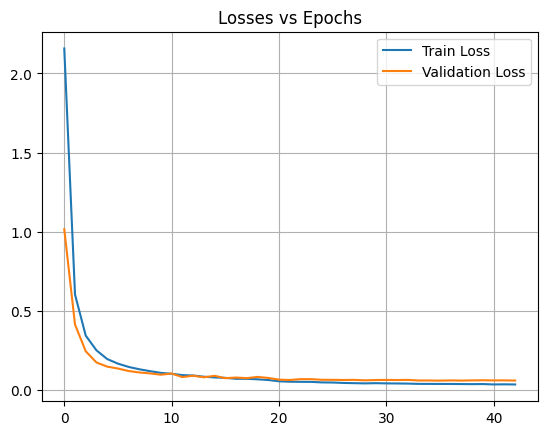

In [68]:
trainer.plot_losses()

In [69]:
# evaluate model
test_loss, accuracy, conf_mat = trainer.evaluate(test_dl)

Test Loss: 0.0445
Test Accuracy: 98.51%
Test Confusion Matrix: 
[[ 972    0    0    0    1    0    2    3    1    1]
 [   0 1130    2    1    0    0    1    1    0    0]
 [   1    0 1019    2    0    3    4    1    1    1]
 [   0    0    2  995    0    7    0    3    1    2]
 [   0    0    1    0  973    0    0    2    0    6]
 [   1    0    9    8    0  863    4    4    2    1]
 [   6    2    9    1    1    1  938    0    0    0]
 [   0    2    3    0    0    3    0 1015    1    4]
 [   1    0    0    5    1    1    1    4  958    3]
 [   1    0    0    3    7    4    0    5    1  988]]


In [70]:
# utils

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, PrecisionRecallDisplay

def display_conf_mat(conf_mat,display_labels=None):
    cm_disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=display_labels
    )
    cm_disp.plot()
    plt.show()

    
def calc_precision(y_true,y_pred):
    return precision_score(y_true,y_pred)

   
def calc_recall(y_true,y_pred):
    return recall_score(y_true,y_pred)

In [71]:
mnist_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

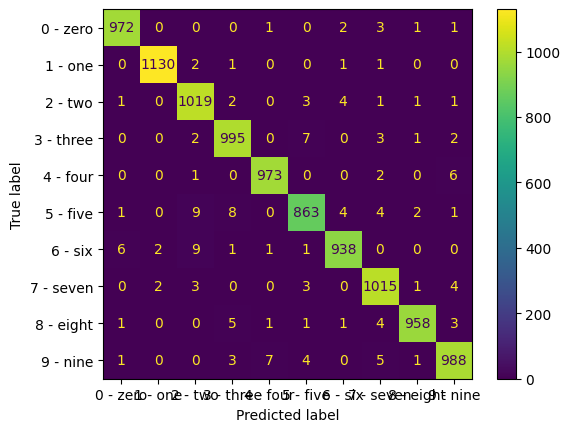

In [72]:
display_conf_mat(conf_mat=conf_mat,display_labels=mnist_classes)

In [291]:
# # calc precision recall - can add more metrics in utils in the future

# all_labels, all_predictions = trainer.inference_dataloader(test_dl)
# precision = calc_precision(all_labels, all_predictions)
# recall = calc_recall(all_labels, all_predictions)

# print(f'Test Precision: {precision :.2%}')
# print(f'Test Recall: {recall :.2%}')

In [292]:
# sample_image_path = df.iloc[0,0]
# logits, predicted_class = trainer.inference_one_image(image_path=sample_image_path,input_dim=64)
# logits, predicted_class

In [293]:
# sample_image_path_list = df.iloc[:10,0]
# all_logits, all_predicted_class = trainer.inference_list_images(image_path_list=sample_image_path_list,input_dim=64)
# all_logits, all_predicted_class

## load pretrained model and start new training

In [99]:
os.listdir('./checkpoints/mnist')

['epoch1.pt',
 'epoch16.pt',
 'epoch22.pt',
 'epoch5.pt',
 'epoch12.pt',
 'epoch36.pt',
 'epoch4.pt',
 'epoch29.pt',
 'epoch9.pt',
 'epoch8.pt',
 'epoch10.pt',
 'epoch7.pt',
 'epoch34.pt',
 'epoch14.pt',
 'epoch3.pt',
 'epoch2.pt',
 'epoch21.pt',
 'epoch6.pt',
 'epoch35.pt']

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_channels=1).to(device)

# load pretrained model
checkpoint_path = './checkpoints/mnist/epoch10.pt'
model.load_model(checkpoint_path)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# train with new statistics
trainer = Trainer(model, criterion, optimizer, device, patience=7)

# Train the model
trainer.train(train_dl, val_dl, epochs=40, save_path='./checkpoints/mnist2')

model loaded from ./checkpoints/mnist/epoch10.pt


/Users/I748920/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 0.0994, Validation Loss: 0.0901, Validation Acc: 0.9731, Epoch Duration: 11.4s
model saved to ./checkpoints/mnist2/epoch1.pt
Epoch 2, Training Loss: 0.0971, Validation Loss: 0.0850, Validation Acc: 0.9746, Epoch Duration: 11.4s
model saved to ./checkpoints/mnist2/epoch2.pt
Epoch 3, Training Loss: 0.0898, Validation Loss: 0.0920, Validation Acc: 0.9726, Epoch Duration: 11.3s
Epoch 4, Training Loss: 0.0844, Validation Loss: 0.0789, Validation Acc: 0.9772, Epoch Duration: 11.1s
model saved to ./checkpoints/mnist2/epoch4.pt
Epoch 5, Training Loss: 0.0811, Validation Loss: 0.0843, Validation Acc: 0.9745, Epoch Duration: 10.4s
Epoch 6, Training Loss: 0.0751, Validation Loss: 0.0719, Validation Acc: 0.9799, Epoch Duration: 10.7s
model saved to ./checkpoints/mnist2/epoch6.pt
Epoch 7, Training Loss: 0.0718, Validation Loss: 0.0740, Validation Acc: 0.9776, Epoch Duration: 10.8s
Epoch 8, Training Loss: 0.0675, Validation Loss: 0.0797, Validation Acc: 0.9761, Epoch Duration

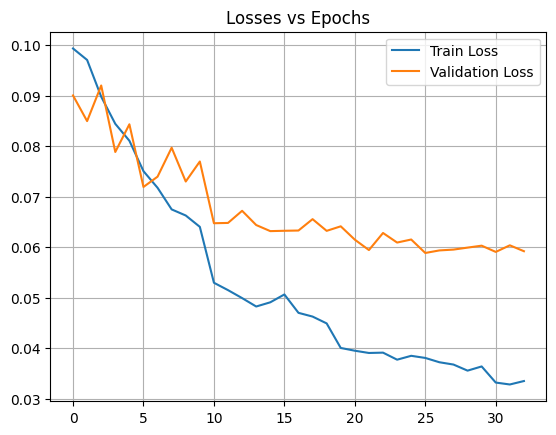

In [110]:
trainer.plot_losses()

In [111]:
# evaluate model
test_loss, accuracy, conf_mat = trainer.evaluate(test_dl)

Test Loss: 0.0447
Test Accuracy: 98.54%
Test Confusion Matrix: 
[[ 971    1    0    0    1    1    1    3    1    1]
 [   0 1130    2    1    0    0    1    1    0    0]
 [   0    0 1011    3    0    9    4    3    1    1]
 [   0    0    1 1003    0    5    0    1    0    0]
 [   0    0    1    0  975    0    0    1    0    5]
 [   1    0    7   10    0  863    4    4    2    1]
 [   6    3    5    1    2    3  938    0    0    0]
 [   0    2    4    1    1    1    0 1015    0    4]
 [   1    0    0    5    1    1    1    3  959    3]
 [   1    0    0    2    8    4    0    4    1  989]]


In [112]:
# utils

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, PrecisionRecallDisplay

def display_conf_mat(conf_mat,display_labels=None):
    cm_disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=display_labels
    )
    cm_disp.plot()
    plt.show()

    
def calc_precision(y_true,y_pred):
    return precision_score(y_true,y_pred)

   
def calc_recall(y_true,y_pred):
    return recall_score(y_true,y_pred)

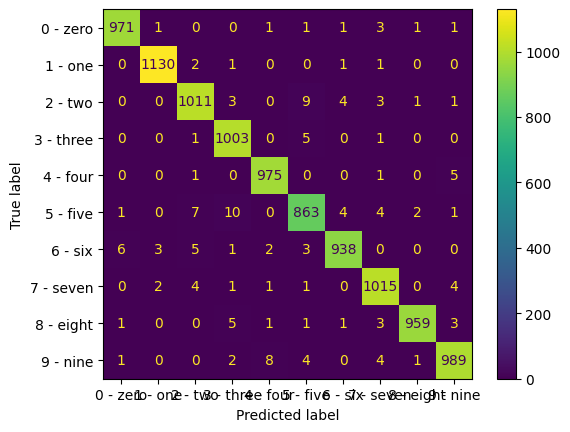

In [118]:
display_conf_mat(conf_mat=conf_mat,display_labels=mnist_classes)

In [ ]:
# # calc precision recall - can add more metrics in utils in the future

# all_labels, all_predictions = trainer.inference_dataloader(test_dl)
# precision = calc_precision(all_labels, all_predictions)
# recall = calc_recall(all_labels, all_predictions)

# print(f'Test Precision: {precision :.2%}')
# print(f'Test Recall: {recall :.2%}')

In [ ]:
# sample_image_path = df.iloc[0,0]
# logits, predicted_class = trainer.inference_one_image(image_path=sample_image_path,input_dim=64)
# logits, predicted_class

In [ ]:
# sample_image_path_list = df.iloc[:10,0]
# all_logits, all_predicted_class = trainer.inference_list_images(image_path_list=sample_image_path_list,input_dim=64)
# all_logits, all_predicted_class

## load pretrained model and resume training from specified checkpoint

In [124]:
os.listdir('./checkpoints/mnist')

['epoch1.pt',
 'epoch16.pt',
 'epoch22.pt',
 'epoch5.pt',
 'epoch12.pt',
 'epoch36.pt',
 'epoch4.pt',
 'epoch29.pt',
 'epoch9.pt',
 'epoch8.pt',
 'epoch10.pt',
 'epoch7.pt',
 'epoch34.pt',
 'epoch14.pt',
 'epoch3.pt',
 'epoch2.pt',
 'epoch21.pt',
 'epoch6.pt',
 'epoch35.pt']

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_channels=1).to(device)

# load pretrained model
checkpoint_path = './checkpoints/mnist/epoch10.pt'
model.load_model(checkpoint_path)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# train with new statistics
trainer = Trainer(model, criterion, optimizer, device, patience=7)

# Train the model
trainer.resume_training(checkpoint_path, train_dl, val_dl, epochs=10, save_path='./checkpoints/mnist3')

model loaded from ./checkpoints/mnist/epoch10.pt
loaded training checkpoint from ./checkpoints/mnist/epoch10.pt
Pre-training Epoch 0, Training Loss: 0.1071, Validation Loss: 0.0955, Validation Acc: 0.9729

##### RESUME TRAINING #####


/Users/I748920/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 0.1003, Validation Loss: 0.1067, Validation Acc: 0.9689, Epoch Duration: 11.3s
Epoch 2, Training Loss: 0.0979, Validation Loss: 0.0952, Validation Acc: 0.9719, Epoch Duration: 11.2s
model saved to ./checkpoints/mnist3/epoch2.pt
Epoch 3, Training Loss: 0.0889, Validation Loss: 0.0806, Validation Acc: 0.9769, Epoch Duration: 11.2s
model saved to ./checkpoints/mnist3/epoch3.pt
Epoch 4, Training Loss: 0.0830, Validation Loss: 0.0826, Validation Acc: 0.9771, Epoch Duration: 11.2s
Epoch 5, Training Loss: 0.0782, Validation Loss: 0.0753, Validation Acc: 0.9782, Epoch Duration: 11.2s
model saved to ./checkpoints/mnist3/epoch5.pt
Epoch 6, Training Loss: 0.0786, Validation Loss: 0.0787, Validation Acc: 0.9764, Epoch Duration: 11.2s
Epoch 7, Training Loss: 0.0704, Validation Loss: 0.0775, Validation Acc: 0.9774, Epoch Duration: 11.2s
Epoch 8, Training Loss: 0.0686, Validation Loss: 0.0722, Validation Acc: 0.9784, Epoch Duration: 11.4s
model saved to ./checkpoints/mnist3/ep

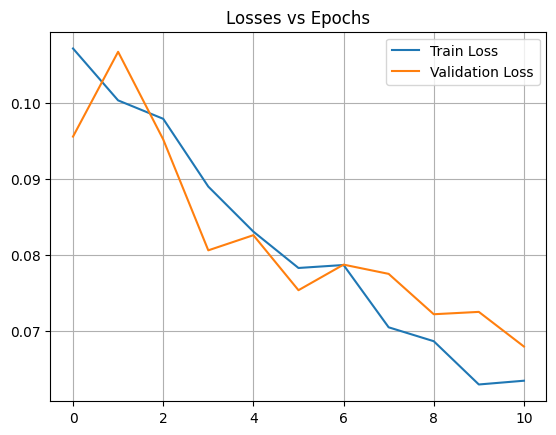

In [135]:
trainer.plot_losses()

In [128]:
# evaluate model
test_loss, accuracy, conf_mat = trainer.evaluate(test_dl)

Test Loss: 0.0567
Test Accuracy: 98.14%
Test Confusion Matrix: 
[[ 973    0    0    0    0    2    2    1    1    1]
 [   0 1128    5    0    0    0    1    1    0    0]
 [   0    0 1015    1    0    5    7    4    0    0]
 [   0    1    3  987    0    8    0    6    5    0]
 [   0    0    1    0  977    0    0    0    0    4]
 [   1    0   23    7    0  849    4    6    1    1]
 [   6    3   10    0    3    0  936    0    0    0]
 [   0    2    5    0    1    2    0 1011    1    6]
 [   1    0    1    4    0    3    1    6  955    3]
 [   2    0    3    1    9    4    0    4    3  983]]


In [129]:
# utils

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, PrecisionRecallDisplay

def display_conf_mat(conf_mat,display_labels=None):
    cm_disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat,
        display_labels=display_labels
    )
    cm_disp.plot()
    plt.show()

    
def calc_precision(y_true,y_pred):
    return precision_score(y_true,y_pred)

   
def calc_recall(y_true,y_pred):
    return recall_score(y_true,y_pred)

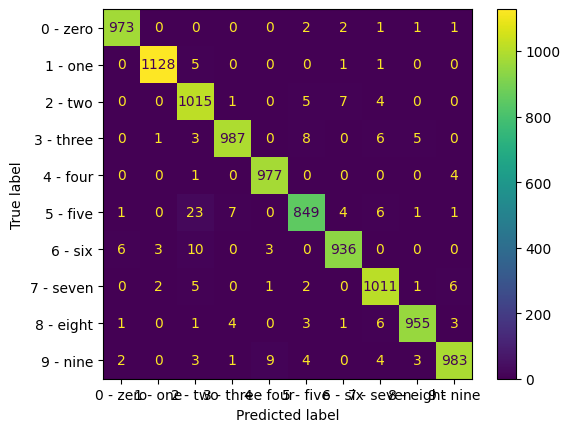

In [130]:
display_conf_mat(conf_mat=conf_mat,display_labels=mnist_classes)

In [ ]:
# # calc precision recall - can add more metrics in utils in the future

# all_labels, all_predictions = trainer.inference_dataloader(test_dl)
# precision = calc_precision(all_labels, all_predictions)
# recall = calc_recall(all_labels, all_predictions)

# print(f'Test Precision: {precision :.2%}')
# print(f'Test Recall: {recall :.2%}')

In [ ]:
# sample_image_path = df.iloc[0,0]
# logits, predicted_class = trainer.inference_one_image(image_path=sample_image_path,input_dim=64)
# logits, predicted_class

In [ ]:
# sample_image_path_list = df.iloc[:10,0]
# all_logits, all_predicted_class = trainer.inference_list_images(image_path_list=sample_image_path_list,input_dim=64)
# all_logits, all_predicted_class

# to do
** !! ensure that the codes added to Trainer are generic and not too specific, else the code wont serve its purpose of being generalisable!!
-the extra stuff just put in utils, like balance for e.g.

<!-- implement inference 

def inference_one_image()

def inference_list_images() - function will convert to tensor and apply the val_transforms -->

<!-- implement model saving 
-model saving of most recent epoch (most basic) or after val loss drops (default option should be the first one, integrate with early stopping?)
-then checkpointing (next cell) -->

<!-- integrate with training model from load_model cehckpoint, either finetune from there, or continue training from the same expt statistics -->

<!-- implement checkpointing - not just model, but entire state of training as well
 
https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/4
https://machinelearningmastery.com/managing-a-pytorch-training-process-with-checkpoints-and-early-stopping/ -->

<!-- implement load model checkpoint and train to finetune (new training statistics) or continue train from previous checkpoint (use training statistics) -->

<!-- training script training options to implement, can pass as parameter in argparse -->

<!-- - from scratch: ... > trainer.train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = Trainer(model, criterion, optimizer, device, patience=7)
trainer.train(train_dl, val_dl, epochs=10)

- train from loaded model with new training stats: ... > load pretrained model > trainer.train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = Trainer(model, criterion, optimizer, device, patience=7)
trainer.train(train_dl, val_dl, epochs=10)

- resume training from loaded model previous training stats: ... > load pretrained model > trainer.resume_train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = Trainer(model, criterion, optimizer, device, patience=7)
trainer.resume_train(checkpoint_path,train_dl, val_dl, epochs=10) -->

<!-- trainer class 

put the model loading in the model class instead of trainer class, but can still leave the load_model for direct inference usage in the trainer class -->

<!-- watch video and see how code can be cleaned

https://www.youtube.com/watch?v=YJ1wSxbqqo8&list=PLLeO8f6PhlKb_FAC7qxOBtxT9-8EPDAqk&index=6 -->

<!-- experiment code to solve MNIST dataset task on local using notebook -->

plan these 3 expts

<!-- - train from scratch
- finetune pretrained model with new training
- resume training

* need to run 3 expts
    * A: run training from scratch for 100 epochs
    * B: load pretrained model and train with new optimizer and scheduler
    * C: load checkpoint and resume training
     -->
compare B & C to A, it should match super closely since its practically the same traning --> can combine the training and val losses before and after to see if they match A expts

convert the codes to python scripts - train.py and utils.py
-implement the if name == main

extract the evaluation code from train.py and put in evaluate.py, but just comment the code out in train.py, dont delete
-implement the if name == main
-evaluate means test

look thru gojek train.py for anything missing, additional details that are abit hardcoded can be added to utils
check evaluate.py
check sample_trainer_class.py

simplify EarlyStopping

integrate argparse and yaml (refer to gojek train.py)

clean model class, create some samples

clean Dataset class - can make it generic? - maybe for dataset class abit hard to make it generic since its specific to each project, but trainer class shud be

train on MNIST again but using scripts on local
-try diff model architectures
-list several optimizer and scheduler methods in comments for usage

use Colab to solve the MRL dataset 

try diff image datasets tasks

see if the code can easily be adapted to other areas like time series --> try on the DSA5205 project